# Point cloud registration
In this notebook I explore point cloud registration which would be the basis for a 3D odometry stage. For registration the typical approach is the iterative Closest Point algorithm. I have tested Point-to-Plane ICP, Multi-scale ICP and Colored ICP 

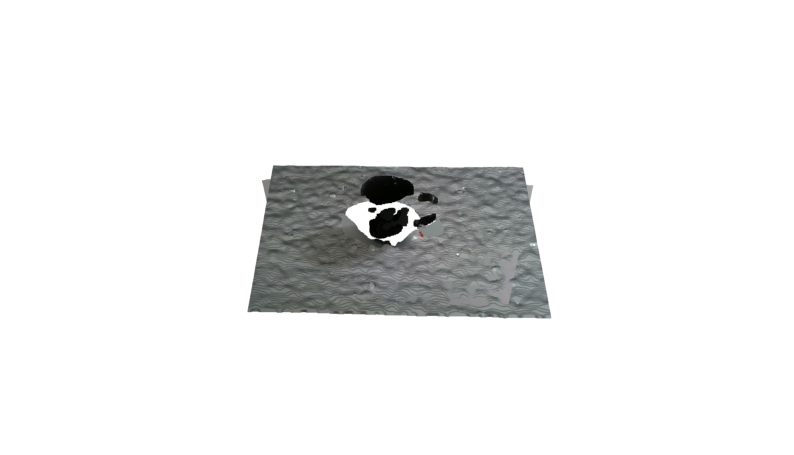

Inlier Fitness:  0.9677990092002831
Inlier RMSE:  0.00329404452441686


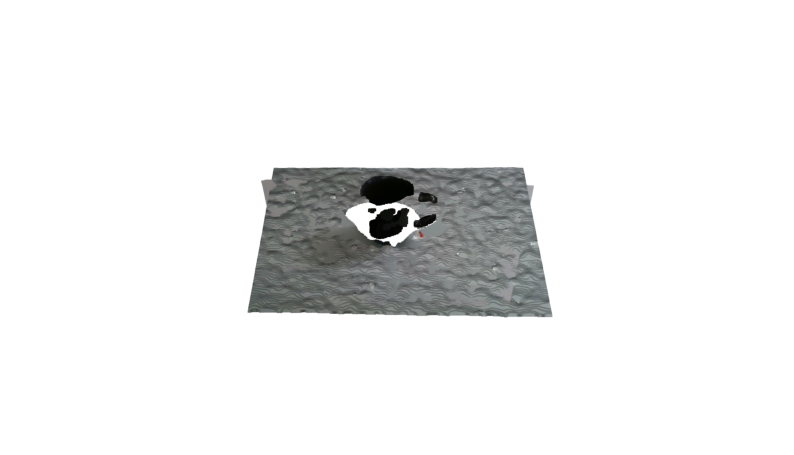

In [10]:
import open3d as o3d
import numpy as np
from reconstruction.dataset import Dataset
import reconstruction.utils.visualization as vis



def draw_registration_result(source, target, transformation):
    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    transformed_target = target.clone().transform(transformation)
    vis.visualize_geometry([source.to_legacy(),
         transformed_target.to_legacy()], flip=True)


def extract_point_cloud(depth_file: str, color_file: str, intrinsic: o3d.core.Tensor) -> o3d.geometry.PointCloud:
    depth_image = o3d.t.io.read_image(depth_file)
    color_image = o3d.t.io.read_image(color_file)
    rgbd_image = o3d.t.geometry.RGBDImage(color_image, depth_image)
    
    pcd = o3d.t.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        intrinsic,
        depth_scale=1000.0,
        depth_max=0.5)

    return pcd


def icp_point_to_plane(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane()
    criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                        relative_rmse=0.0000001,
                                        max_iteration=100)
    max_correspondence_distance = 0.015

    reg = o3d.t.pipelines.registration.icp(source, target, max_correspondence_distance,
                                initial_transform, estimation, criteria, voxel_size=0.005)
    
    return reg


dataset = Dataset.read("data/3d-scans-cap-black-glossy-ha-2019-02-27T16_06_29")
source_frame = dataset.frames[51]
target_frame = dataset.frames[63]
camera_intrinsic = o3d.core.Tensor([[613.688, 0.0, 323.035], 
                            [0.0, 614.261, 242.229], 
                            [0.0, 0.0, 1.0]])

source = extract_point_cloud(source_frame.depth_file, source_frame.color_file, camera_intrinsic)
target = extract_point_cloud(target_frame.depth_file, target_frame.color_file, camera_intrinsic)
target.estimate_normals()
relative_transform = np.matmul(np.linalg.inv(source_frame.get_transform()), target_frame.get_transform())
vis.visualize_geometry([source.to_legacy(), target.to_legacy().transform(relative_transform)], flip=True)

registration_result = icp_point_to_plane(source, target, np.linalg.inv(relative_transform))
print("Inlier Fitness: ", registration_result.fitness)
print("Inlier RMSE: ", registration_result.inlier_rmse)
draw_registration_result(source, target, np.linalg.inv(registration_result.transformation.numpy()))

  0%|          | 0/194 [00:00<?, ?it/s]

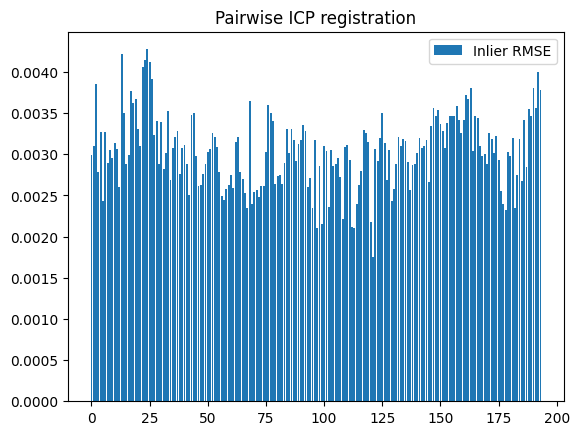

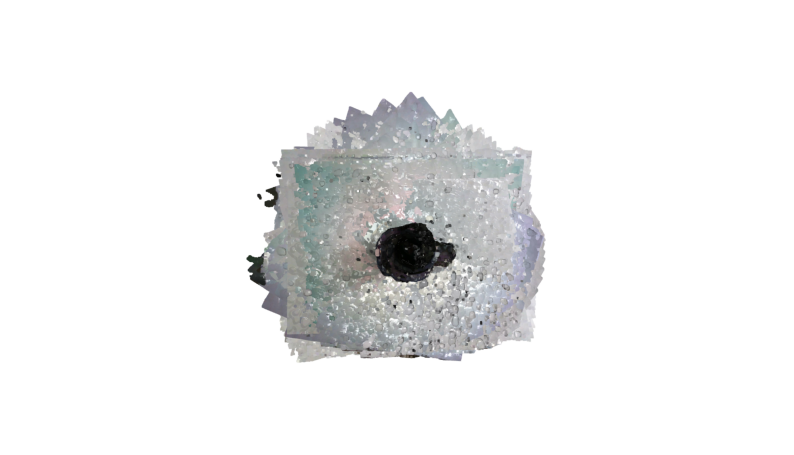

0.5913227993773134

In [2]:
from tqdm.notebook import tqdm
from itertools import accumulate
from more_itertools import pairwise
import matplotlib.pyplot as plt
import logging

def register_frames(dataset: Dataset, method):
    progress_bar = tqdm(total=len(dataset.frames) - 1)
    meshes = []
    inlier_rmses = []

    transforms = []
    prev_point_cloud = None
    for source_frame, target_frame in pairwise(dataset.frames):
        # Optimization to avoid loading a point cloud twice
        if prev_point_cloud is None:
            source_point_cloud = extract_point_cloud(source_frame.depth_file, source_frame.color_file, camera_intrinsic)
        else:
            source_point_cloud = prev_point_cloud
        target_point_cloud = extract_point_cloud(target_frame.depth_file, target_frame.color_file, camera_intrinsic)
        target_point_cloud.estimate_normals()
        initial_transform = np.matmul(np.linalg.inv(source_frame.get_transform()), target_frame.get_transform())
        
        # It can fail due to singular matrices
        try:
            registration_result = method(source_point_cloud, target_point_cloud, np.linalg.inv(initial_transform))
            transforms.append(np.matmul(source_frame.get_transform(), np.linalg.inv(registration_result.transformation.numpy())))
            meshes.append(target_point_cloud.to_legacy())
            
            inlier_rmses.append(registration_result.inlier_rmse)
            progress_bar.set_description(f"Registered frame {source_frame.id} to {target_frame.id}")
            progress_bar.set_postfix(fitness=registration_result.fitness, inlier_rmse=registration_result.inlier_rmse)
            progress_bar.update()
            prev_point_cloud = target_point_cloud

        except RuntimeError as e:
            logging.warning(e)
            inlier_rmses.append(0)
            progress_bar.update()

    progress_bar.close()

    for transform, mesh in zip(transforms, meshes):
        mesh.transform(transform)

    x = np.arange(0, len(inlier_rmses))
    y = inlier_rmses
    fig = plt.figure()
    ax = plt.axes()
    plt.title("Pairwise ICP registration")
    ax.bar(x, y, label="Inlier RMSE")
    ax.legend()

    vis.visualize_geometry(meshes, flip=False)

    return np.sum(inlier_rmses)

register_frames(dataset, method=icp_point_to_plane)

**Baseline**

  0%|          | 0/194 [00:00<?, ?it/s]

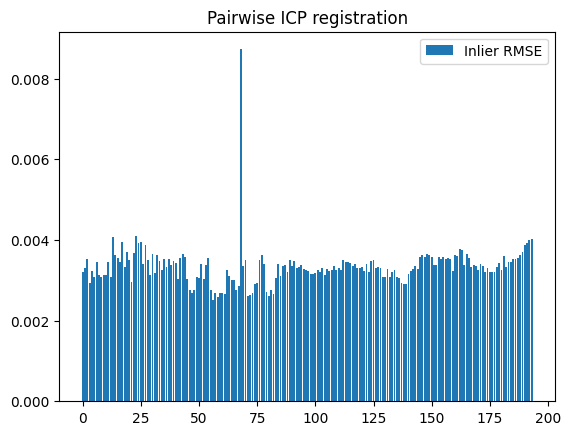

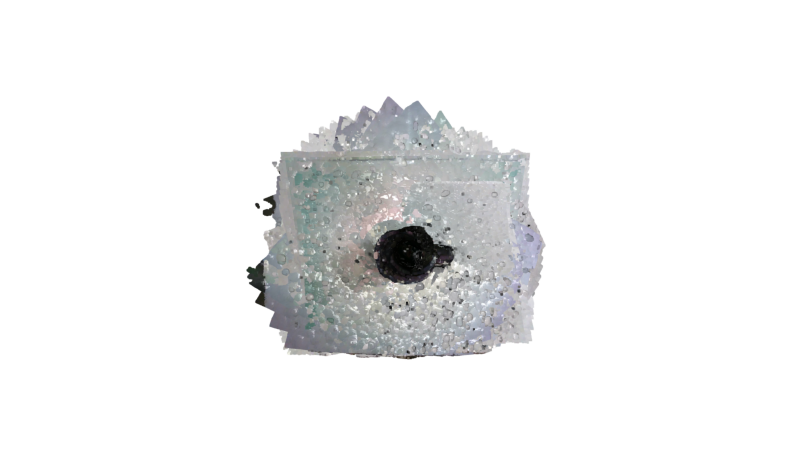

**ICP Point-to-plane**

  0%|          | 0/194 [00:00<?, ?it/s]

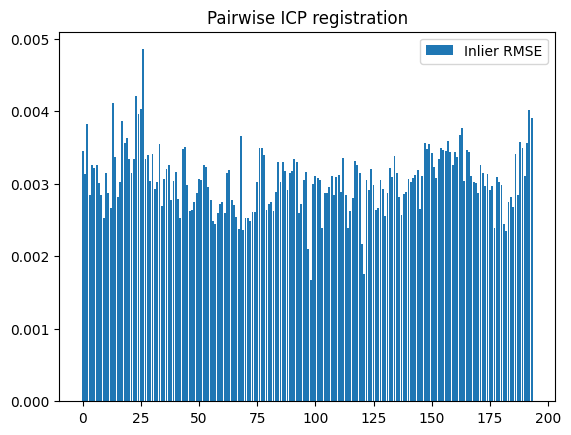

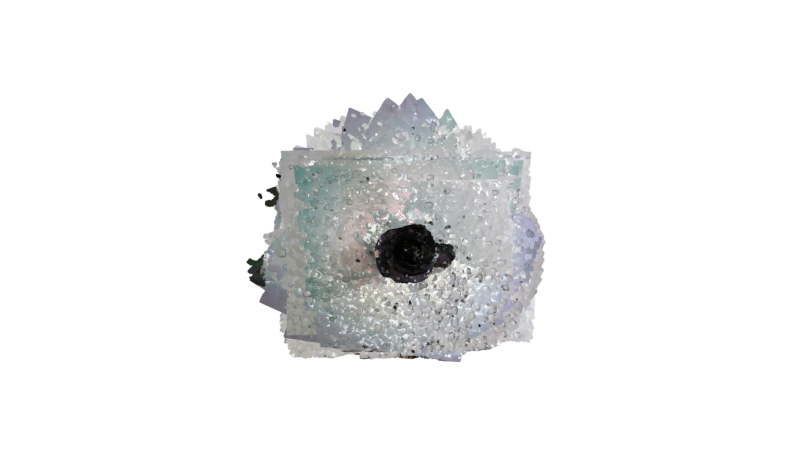

**ICP Color**

  0%|          | 0/194 [00:00<?, ?it/s]

[Open3D WARNING] 0 correspondence present between the pointclouds. Try increasing the max_correspondence_distance parameter.


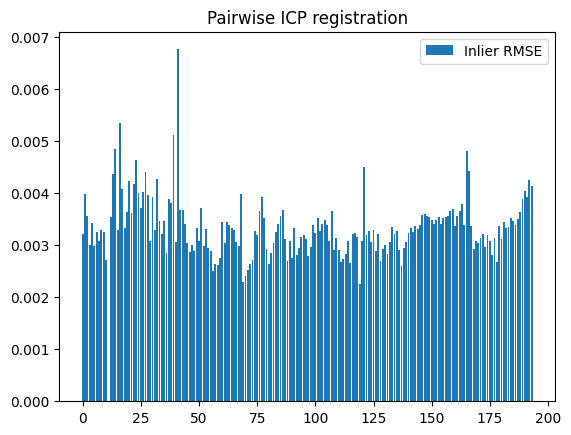

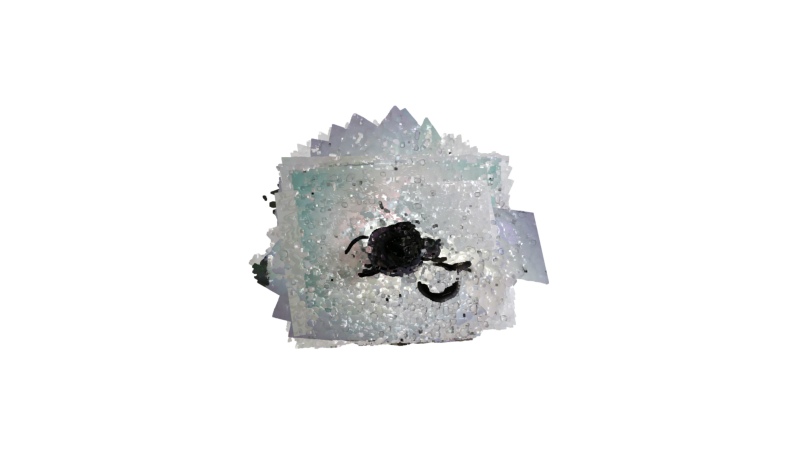


**Baseline RMSE:** 0.6476555016432224
**Point-to-plane ICP RMSE:** 0.5935595341220443
**Colored ICP RMSE:** 0.6474301256293313


In [3]:
from IPython.display import display, Markdown

def icp_color(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationForColoredICP()
    criterias = [
        o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0001,
                                    relative_rmse=0.0001,
                                    max_iteration=100),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.00001, 0.00001, 30),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.000001, 0.000001, 15)
    ]
    max_correspondence_distances = o3d.utility.DoubleVector([0.06, 0.03, 0.015])
    voxel_sizes = o3d.utility.DoubleVector([0.02, 0.01, 0.005])

    reg_point_to_plane_color = o3d.t.pipelines.registration.multi_scale_icp(source, target, voxel_sizes, criterias, max_correspondence_distances,
                                initial_transform, estimation)

    return reg_point_to_plane_color

def noop(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane()
    criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                        relative_rmse=0.0000001,
                                        max_iteration=0)
    max_correspondence_distance = 0.015

    reg = o3d.t.pipelines.registration.icp(source, target, max_correspondence_distance,
                                initial_transform, estimation, criteria, voxel_size=0.005)
    
    return reg

display(Markdown(f"**Baseline**"))
baseline_rmse = register_frames(dataset, method=noop)

display(Markdown(f"**ICP Point-to-plane**"))
icp_rmse = register_frames(dataset, method=icp_point_to_plane)

display(Markdown(f"**ICP Color**"))
icp_color_rmse = register_frames(dataset, method=icp_color)

display(Markdown(f"""
**Baseline RMSE:** {baseline_rmse}
**Point-to-plane ICP RMSE:** {icp_rmse}
**Colored ICP RMSE:** {icp_color_rmse}
"""))